In [1]:
# set tf 1.x for colab
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

We're using TF 1.15.0


Using TensorFlow backend.


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [2]:
grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
                        all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [16]:
# token expires every 30 min
COURSERA_TOKEN = "CQfoFTt00Jnp7IGM"
COURSERA_EMAIL = "valentin.goriachev@yandex.ru"

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [4]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


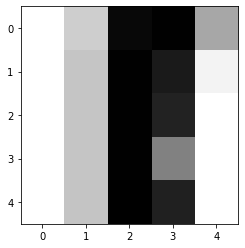

And the whole sample:


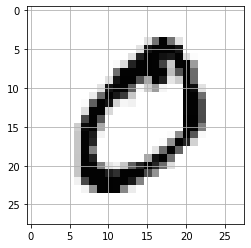

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [5]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.grid()
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [6]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [7]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [7]:
tf.get_variable("x", shape=(), dtype=tf.float32)

<tf.Variable 'x:0' shape=() dtype=float32_ref>

In [22]:
# run this again if you remake your graph
s = reset_tf_session()

In [23]:
# Model parameters: W and b
W = tf.get_variable("W", shape=(784, 10)) #with shape[0] = 784
b = tf.get_variable('b', shape=(1,10))

In [24]:
# Placeholders for the input data
input_X = tf.placeholder('float32', shape=(None, 784)) #for flat X with shape[0] = None for any batch size
input_y = tf.placeholder('int32', shape=(None, 10))    #for one-hot encoded true labels

In [25]:
# Compute predictions
logits = input_X @ W + b # logits for input_X, resulting shape should be [input_X.shape[0], 10]
probas = tf.nn.softmax(logits)# apply tf.nn.softmax to logits
classes =tf.argmax(probas, axis=1) # apply tf.argmax to find a class index with highest probability

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).

#lablel_y = tf.one_hot( input_y,  10)

loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(input_y, 
                                               logits))# cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
optimizer = tf.train.AdamOptimizer(0.001)
step = optimizer.minimize(loss) # optimizer step that minimizes the loss

0.93
Wall time: 14.1 s


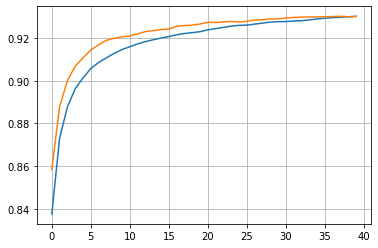

In [26]:
%%time
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")
tr_ac = []
val_ac = []
for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)
        
    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    tr_ac.append(train_accuracy)
    val_ac.append(valid_accuracy)
    #simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)
plt.plot(tr_ac)
plt.plot(val_ac)
plt.grid()
print(accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [ ]:
X_train_flat.shape

In [138]:
s = reset_tf_session()
input_y = tf.placeholder('int32', shape=(None, ))  
lablel_y = tf.one_hot( input_y,  10)
s.run(lablel_y, feed_dict={input_y: np.array([1,2,3,4,5,6]).T})

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [14]:
X_test = X_train_flat[0:5]

y_test = y_train_oh[0:5]
print(X_test.shape, y_test.shape)

(5, 784) (5, 10)


In [15]:

s.run(hidden2, {input_X: X_test}).shape

(5, 256)

In [16]:
s.run(logits, {input_X: X_test})

array([[45.53654 , 45.81085 , 45.25112 , 45.75158 , 45.37371 , 45.623894,
        45.14242 , 45.946552, 45.9056  , 45.598633],
       [45.53654 , 45.81085 , 45.25112 , 45.75158 , 45.37371 , 45.623894,
        45.14242 , 45.946552, 45.9056  , 45.598633],
       [45.53654 , 45.81085 , 45.25112 , 45.75158 , 45.37371 , 45.623894,
        45.14242 , 45.946552, 45.9056  , 45.598633],
       [45.53654 , 45.81085 , 45.25112 , 45.75158 , 45.37371 , 45.623894,
        45.14242 , 45.946552, 45.9056  , 45.598633],
       [45.53654 , 45.81085 , 45.25112 , 45.75158 , 45.37371 , 45.623894,
        45.14242 , 45.946552, 45.9056  , 45.598633]], dtype=float32)

In [17]:
s.run(probas, {input_X: X_test})

array([[0.09140944, 0.12026002, 0.06871238, 0.11333944, 0.07767384,
        0.09975344, 0.06163498, 0.13773894, 0.13221236, 0.09726514],
       [0.09140944, 0.12026002, 0.06871238, 0.11333944, 0.07767384,
        0.09975344, 0.06163498, 0.13773894, 0.13221236, 0.09726514],
       [0.09140944, 0.12026002, 0.06871238, 0.11333944, 0.07767384,
        0.09975344, 0.06163498, 0.13773894, 0.13221236, 0.09726514],
       [0.09140944, 0.12026002, 0.06871238, 0.11333944, 0.07767384,
        0.09975344, 0.06163498, 0.13773894, 0.13221236, 0.09726514],
       [0.09140944, 0.12026002, 0.06871238, 0.11333944, 0.07767384,
        0.09975344, 0.06163498, 0.13773894, 0.13221236, 0.09726514]],
      dtype=float32)

In [18]:
s.run(classes, {input_X: X_test})

array([7, 7, 7, 7, 7], dtype=int64)

# Submit a linear model

In [27]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([W, b, input_X, input_y, logits, probas, classes]))
# Validation loss
grader.set_answer("vmogZ", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy
grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [32]:
s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})

0.25510022

In [33]:
accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))

0.9306

In [28]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [11]:
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.
#logits = input_X @ W + b # logits for input_X, resulting shape should be [input_X.shape[0], 10]



hidden1 = tf.layers.dense(input_X,256, activation=tf.nn.sigmoid)

hidden2 = tf.layers.dense(hidden1,256,activation=tf.nn.sigmoid)

logits = tf.layers.dense(hidden2,10)

loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(input_y, 
                                               logits))# cross-entropy loss
probas = tf.nn.softmax(logits)# apply tf.nn.softmax to logits
classes =tf.argmax(probas, axis=1) # apply tf.argmax to find a class index with highest probability

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer().minimize(loss)
#step = optimizer.minimize(loss) # optimizer step that minimizes the los

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


0.9784
Wall time: 16.2 s


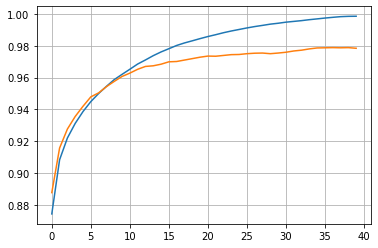

In [12]:
%%time
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
tr_ac = []
val_ac = []
for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)
        
    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    tr_ac.append(train_accuracy)
    val_ac.append(valid_accuracy)
    #simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)
plt.plot(tr_ac)
plt.plot(val_ac)
plt.grid()
print(accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [29]:
s.close()

# Submit the MLP with 2 hidden layers
Run these cells after training the MLP with 2 hidden layers

In [20]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy for MLP
grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [18]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", 0.31)
# Validation accuracy for MLP
grader.set_answer("rE763", 0.9712343)

In [14]:
s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})

0.08034505

In [15]:
accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))

0.9784

In [21]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
